In [10]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
import sys
from tifffile import imread

# Change this folder to where the cloned `alignment` repository is
sys.path.insert(0, '/Users/minelarinel/alignment')

from alignment import minmax_scaler
from registration import sitkalignment

logging.getLogger('matplotlib').setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### To align the vagal images, we will use the SUM of the anatomy stack of each recording. So unlike hindbrain, which aligns based on a plane in the functional volume, we will align vagal neurons based on a z-projected anatomy image.

In [11]:
# Folder where the experiment folders are
data_folder = r'/Volumes/Rapid/Arinel_et_al_2025/Data/Fig3'

# Reference data
source_img_path = Path(r'/Volumes/Rapid/Arinel_et_al_2025/Data/alignment/vagal/SUM_vagal_anatomystack_cutout_bcadjusted.tif')

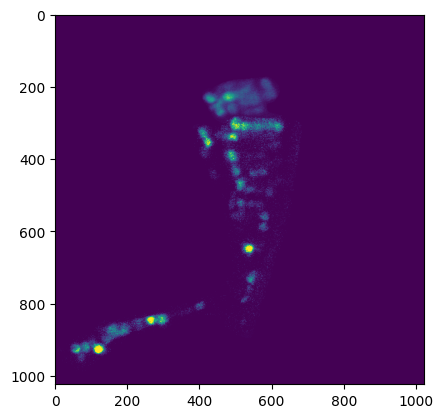

In [12]:
# Load the reference (i.e., source) image
source_img = imread(source_img_path)
source_img = sitkalignment.embed_image(source_img, 1024) # matching image sizes to 1024x1024

source_img = source_img / source_img.max() # rescaling pixel brightness
source_img *= 2**12

plt.imshow(source_img)

## Batch alignment

In [ ]:
# Perform batch alignment on all the experiment folders in the data folder
with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the target (i.e., experiment) image
			target_img_path = os.path.join(exp_folder, "anatomy.tif")
			target_img = imread(target_img_path)

			target_img = np.sum(target_img, axis=0)  # Sum along the z-axis
			target_img = sitkalignment.embed_image(target_img, 1024) # matching image sizes to 1024x1024

			target_img = target_img / target_img.max() # rescaling pixel brightness
			target_img *= 2**12

			# Since the reference is a left vagal ganglion, flip the right vagal ganglion recordings
			flip_horizontal = False
			with os.scandir(exp_folder) as entries:
				for entry in entries:
					if os.path.isdir(entry.path) and entry.name.startswith("vagal_L"):
						break
					elif os.path.isdir(entry.path) and entry.name.startswith("vagal_R"):
						flip_horizontal = True
						target_img = np.fliplr(target_img)
						break
			
			# Change the vmin and vmax settings for better visualization and better alignment
			# Increasing the contrast of landmarks helps with the alignment
			source_vmin = 0
			source_vmax = 1000
			target_vmin = 0
			target_vmax = 1000

			_source_img = minmax_scaler(source_img, vmin=source_vmin, vmax=source_vmax)
			_plot_img = minmax_scaler(target_img, vmin=target_vmin, vmax=target_vmax)

			# Saving the reverse alignment in this path (in the same folder as the functional volume)
			save_path = os.path.join(exp_folder, "alignment_rev")

			# Perform the alignment
			# Can change scalePenalty and iterations. Increase iterations to get better result. Lower scale penalty if you want more warp.
			registered_image = sitkalignment.register_image2(_plot_img, _source_img, save_path, scalePenalty=150, iterations=(10000, 500))

			# Visualize the alignment
			fig, ax = plt.subplots(1, 3, figsize=(14, 6))
			ax[0].imshow(
				target_img,
				cmap="gray",
				vmin=target_vmin,
				vmax=target_vmax
			)
			ax[1].imshow(
				registered_image,
				cmap="gray",
				vmin=source_vmin, vmax=source_vmax
			)
			[a.axis("off") for a in ax]
			merge = np.zeros(
				(target_img.shape[0], target_img.shape[1], 3)
			)  # assumes same size images
			merge[:, :, 0] = 2 * target_img / target_img.max()
			merge[:, :, 1] = 2 * registered_image / registered_image.max()
			ax[-1].imshow(merge)
			ax[0].set_title("target")
			ax[1].set_title("reference")
			ax[-1].set_title("merge")
			plt.show()

			# Load the unrolled_temporal.h5 file to add the reverse transformed points
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))
			df["com_aligned"] = None

			fish_id = int(exp_folder.name.split('_')[-2])
			save_path = exp_folder.joinpath("alignment_rev")

			# Find points on functional stack back to reference stack
			# Randomly select n_points number of points and transform them
			n_points = 10

			mypoints = list()
			coms = random.sample(list(df[df.fish_id == fish_id]["com"]), n_points)
			for x, y in coms:
				if flip_horizontal:
					mypoints.append((1024 - (x * 2), y * 2))
				else:
					mypoints.append((x * 2, y * 2))
				
			rev_points = sitkalignment.transform_points(Path(save_path), mypoints)

			# Plot the original points on the target image vs. transformed points on the reference image
			fig, ax = plt.subplots(1, 2, figsize=(14, 6))
			ax[0].imshow(
				target_img,
				cmap="gray",
				vmin=target_vmin,
				vmax=target_vmax 
			)
			for p in mypoints:
				ax[0].scatter(p[0], p[1])
			ax[0].set_title('original points')
			ax[1].imshow(
				source_img,
				cmap="gray",
				vmin=source_vmin,
				vmax=source_vmax,
			)
			ax[1].set_title('reverse transformed points')
			for p in rev_points:
				ax[1].scatter(p[0], p[1])
			[a.axis("off") for a in ax]
			plt.show()

			# Update the unrolled_temporal.h5 dataframe with the reverse transformed points
			for i, row in df.iterrows():
				if flip_horizontal:
					rev_point = sitkalignment.transform_points(Path(save_path), [(1024 - (row.com[0]*2), row.com[1]*2)])
				else:
					rev_point = sitkalignment.transform_points(Path(save_path), [(row.com[0]*2, row.com[1]*2)])
				df.at[i, "com_aligned"] = (rev_point[0][0], rev_point[0][1])

			df.to_hdf(data_folder.joinpath("unrolled_temporal.h5") , key='unrolled_temporal', mode='w')

ELASTIX version: 5.0.1
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [1, 0, 0, 1, 0, 0]
InitializeTransform took 0.00s
Scales are estimated automatically.
Scales for transform parameters are: [88400.25, 88400.25, 88400.25, 88400.25, 1, 1]
Initialization of all components (before registration) took: 5 ms.
Preparation of the image pyrami

## Individual alignment

In [90]:
# Target data
# Change this exp_folder to each individual fish's experiment folder
exp_folder = Path(r'/Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206')

# Reference data
source_img_path = Path(r'/Volumes/Rapid/Arinel_et_al_2025/Data/alignment/vagal/SUM_vagal_anatomystack_cutout_bcadjusted.tif')

In [92]:
# Load the target image
target_img_path = exp_folder.joinpath("anatomy.tif")
target_img = imread(target_img_path)

target_img = np.sum(target_img, axis=0)  # Sum along the z-axis
target_img = sitkalignment.embed_image(target_img, 1024) # matching image sizes to 1024x1024

target_img = target_img / target_img.max() # rescaling pixel brightness
target_img *= 2**12

# Since the reference is a left vagal ganglion, flip the right vagal ganglion recordings
flip_horizontal = False
with os.scandir(exp_folder) as entries:
    for entry in entries:
        if os.path.isdir(entry.path) and entry.name.startswith("vagal_L"):
            break
        elif os.path.isdir(entry.path) and entry.name.startswith("vagal_R"):
            flip_horizontal = True
            target_img = np.fliplr(target_img)
            break

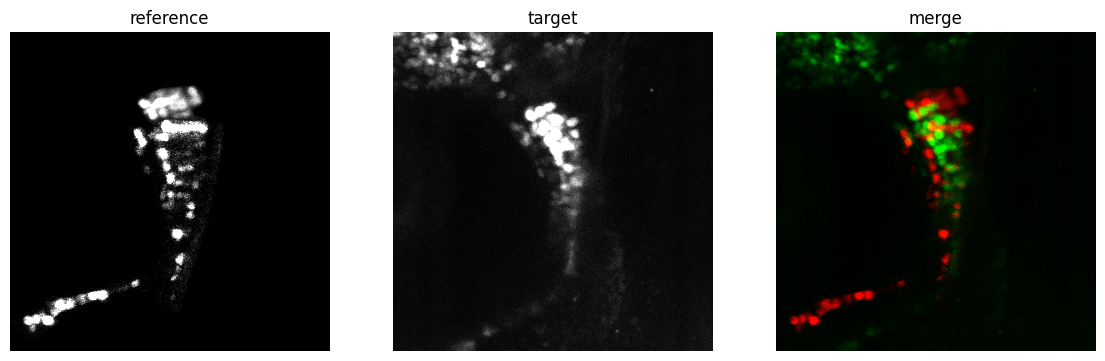

In [93]:
# Visualize unaligned source and target images
# Change the vmin and vmax settings for better visualization and better alignment
# Increasing the contrast of landmarks helps with the alignment
source_vmin = 0
source_vmax = 1000
target_vmin = 0
target_vmax = 1000
plot_img_line_xval = 0  # blocking out top of functional image with 0's
source_img_line_xval = 0  # blocking out top of reference image with 0's

########################################

fig, ax = plt.subplots(1, 3, figsize=(14, 6))

_plot_img = target_img.copy()
_plot_img[0:plot_img_line_xval] = 0

_source_img = source_img.copy()
_source_img[0:source_img_line_xval] = 0

ax[0].imshow(
    _source_img,
    cmap="gray",
    vmin=source_vmin,
    vmax=source_vmax  # max is 4096
)
ax[1].imshow(
    _plot_img, 
    cmap="gray",
    vmin=target_vmin,
    vmax=target_vmax  # max is 4096
)

[a.axis("off") for a in ax]

merge = np.zeros(
    (_source_img.shape[0], _source_img.shape[1], 3)
)  # assumes same size images
merge[:, :, 0] = 2 * _source_img / _source_img.max()
merge[:, :, 1] = 2 * _plot_img / _plot_img.max()
ax[-1].imshow(merge)

ax[0].set_title("reference")
ax[1].set_title("target")
ax[-1].set_title("merge")
plt.show()

In [94]:
_source_img = minmax_scaler(_source_img, vmin=source_vmin, vmax=source_vmax)
_plot_img = minmax_scaler(_plot_img, vmin=target_vmin, vmax=target_vmax)

# Reverse alignment

In [95]:
%%time
# Saving the reverse alignment in this path (in the same folder as the functional volume)
save_path = exp_folder.joinpath("alignment_rev")

# register_image2 is the correct function to use

# can change scalePenalty and iterations
# increase iterations to get better result
# lower scale penalty if you want more warp

# After finding the right set of parameters, come back here and re-run the code with only a single
# item in the scale_penalties and iterations lists.
scale_penalties = [150]  # try [50, 150, 250]
iterations = [(10000, 500)]

registered_images = list()
for sp in scale_penalties:
	for it in iterations:
		registered_image = sitkalignment.register_image2(_plot_img, _source_img, save_path, scalePenalty=sp, iterations=it)
		registered_images.append(registered_image)

ELASTIX version: 5.0.1
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [1, 0, 0, 1, 0, 0]
InitializeTransform took 0.00s
Scales are estimated automatically.
Scales for transform parameters are: [88400.25, 88400.25, 88400.25, 88400.25, 1, 1]
Initialization of all components (before registration) took: 3 ms.
Preparation of the image pyrami

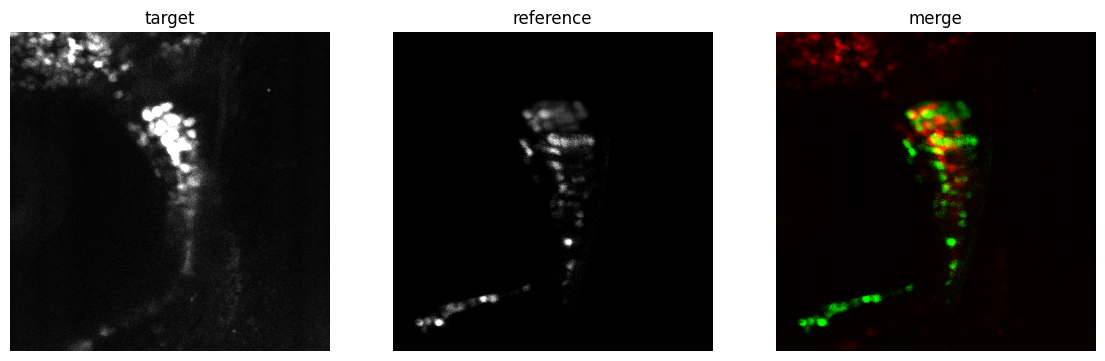

In [96]:
for registered_image in registered_images:
	fig, ax = plt.subplots(1, 3, figsize=(14, 6))

	ax[0].imshow(
		target_img,
		cmap="gray",
		vmin=target_vmin,
		vmax=target_vmax
	)
	ax[1].imshow(
		registered_image,
		cmap="gray",
		vmin=source_vmin, vmax=source_vmax
	)

	[a.axis("off") for a in ax]

	merge = np.zeros(
		(target_img.shape[0], target_img.shape[1], 3)
	)  # assumes same size images
	merge[:, :, 0] = 2 * target_img / target_img.max()
	merge[:, :, 1] = 2 * registered_image / registered_image.max()
	ax[-1].imshow(merge)

	ax[0].set_title("target")
	ax[1].set_title("reference")
	ax[-1].set_title("merge")
	plt.show()

# Find points on functional stack back to reference stack

Checking alignment transformations look good

In [97]:
# Randomly select n_points number of points and transform them
n_points = 10

mypoints = list()
fish_id = int(exp_folder.name.split('_')[-2])
save_path = exp_folder.joinpath("alignment_rev")

coms = random.sample(list(df[df.fish_id == fish_id]["com"]), n_points)
for x, y in coms:
	if flip_horizontal:
		mypoints.append((1024 - (x * 2), y * 2))
	else:
		mypoints.append((x * 2, y * 2))
    
rev_points = sitkalignment.transform_points(Path(save_path), mypoints)

ELASTIX version: 5.0.1
Command line options from ElastixBase:
-out      /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206/alignment_rev/
-threads  unspecified, so all available threads are used
-def      /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206/alignment_rev/point_set.txt
-jac      unspecified, so no det(dT/dx) computed
-jacmat   unspecified, so no dT/dx computed
Calling all ReadFromFile()'s ...
  The default value "false" is used instead.
  The default value "false" is used instead.
  Calling all ReadFromFile()'s took 0.008432 s
Transforming points ...
  The transform is evaluated on some points, specified in the input point file.
  Reading input point file: /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206/alignment_rev/point_set.txt
  Input points are specified in world coordinates.
  Number of specified input points: 10
  The input points are 

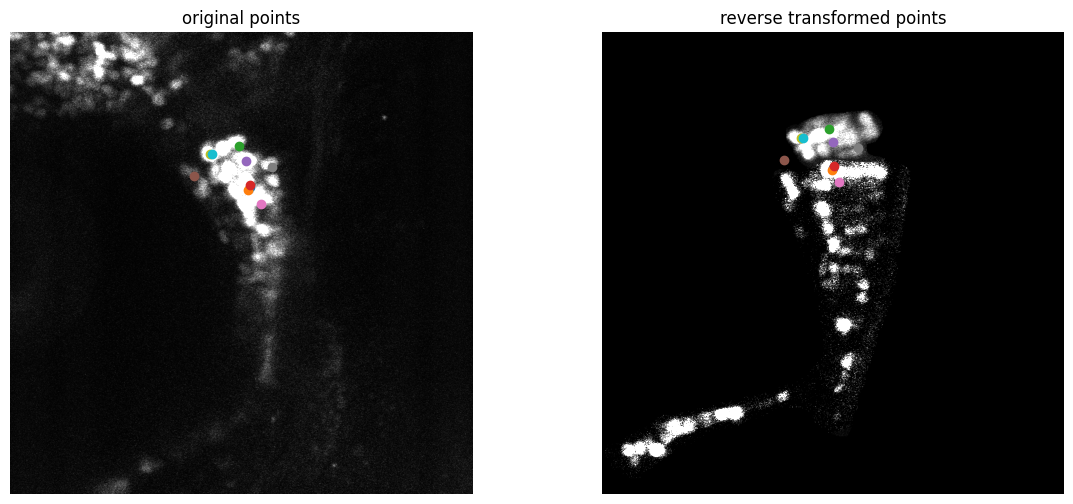

In [98]:
# Plot the original points on the target image vs. transformed points on the reference image
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].imshow(
    target_img,
    cmap="gray",
    vmin=0,
    vmax=1000 
)
for p in mypoints:
    ax[0].scatter(p[0], p[1])
ax[0].set_title('original points')

ax[1].imshow(
    source_img,
    cmap="gray",
    vmin=0,
    vmax=1000,
)
ax[1].set_title('reverse transformed points')
for p in rev_points:
    ax[1].scatter(p[0], p[1])

[a.axis("off") for a in ax]
plt.show()

In [4]:
# Update the unrolled_temporal.h5 dataframe
exps = ["elavl3H2BGCaMP8m_10dpf_fed_eggwater_0mM_9_20230908",
"elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_11_20230913",
"elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_13_20230913",
"elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_14_20230913",
"elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_16_20231206",
"elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_17_20231206",
"elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206"]

data_folder = Path(r'/Volumes/Rapid/Arinel_et_al_2025/Data/Fig3')
df = pd.read_hdf(data_folder.joinpath("unrolled_temporal.h5"))

for exp in exps:
    # Set up paths
	exp_folder = data_folder.joinpath(exp)

	flip_horizontal = False
	with os.scandir(exp_folder) as entries:
		for entry in entries:
			if os.path.isdir(entry.path) and entry.name.startswith("vagal_L"):
				break
			elif os.path.isdir(entry.path) and entry.name.startswith("vagal_R"):
				flip_horizontal = True
				break

	save_path = exp_folder.joinpath("alignment_rev")
	fish_id = int(exp_folder.name.split('_')[-2])

	for i, row in df.iterrows():
		if row.fish_id == fish_id:
			if flip_horizontal:
				rev_point = sitkalignment.transform_points(Path(save_path), [(1024 - (row.com[0]*2), row.com[1]*2)])
			else:
				rev_point = sitkalignment.transform_points(Path(save_path), [(row.com[0]*2, row.com[1]*2)])
			df.at[i, "com_aligned"] = (rev_point[0][0], rev_point[0][1])

df.to_hdf(data_folder.joinpath("unrolled_temporal.h5") , key='unrolled_temporal', mode='w')

ELASTIX version: 5.0.1
Command line options from ElastixBase:
-out      /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_10dpf_fed_eggwater_0mM_9_20230908/alignment_rev/
-threads  unspecified, so all available threads are used
-def      /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_10dpf_fed_eggwater_0mM_9_20230908/alignment_rev/point_set.txt
-jac      unspecified, so no det(dT/dx) computed
-jacmat   unspecified, so no dT/dx computed
Calling all ReadFromFile()'s ...
  The default value "false" is used instead.
  The default value "false" is used instead.
  Calling all ReadFromFile()'s took 0.008539 s
Transforming points ...
  The transform is evaluated on some points, specified in the input point file.
  Reading input point file: /Volumes/Rapid/Arinel_et_al_2025/Data/Fig3/elavl3H2BGCaMP8m_10dpf_fed_eggwater_0mM_9_20230908/alignment_rev/point_set.txt
  Input points are specified in world coordinates.
  Number of specified input points: 1
  The input points are t

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_54379/3010039012.py:37: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['fish_id', 'plane', 'neuron', 'raw_temporal', 'temporal',
       'raw_norm_temporal', 'norm_temporal', 'roi_index', 'com',
       'pulse_frames', 'activated', 'suppressed', 'pulse_response', 'stimulus',
       'region', 'monotonic', 'com_aligned'],
      dtype='object')]

  df.to_hdf(data_folder.joinpath("unrolled_temporal.h5") , key='unrolled_temporal', mode='w')


## Assign neurons to regions

In [5]:
df = pd.read_hdf(data_folder.joinpath("unrolled_temporal.h5"))
reference_img = imread(r'/Volumes/Rapid/Arinel_et_al_2025/Data/alignment/vagal/SUM_vagal_anatomystack.tif')

masks_folder = r"/Volumes/Rapid/Arinel_et_al_2025/Data/alignment/vagal/masks"

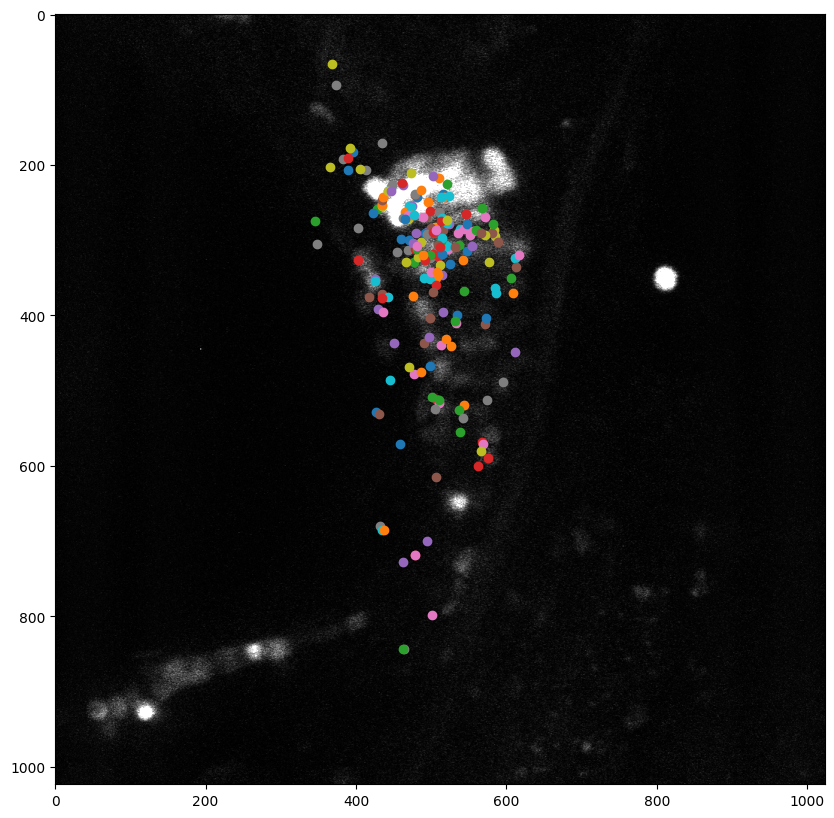

In [7]:
# Visualize the aligned points on the reference image
plt.figure(figsize=(10, 10))
plt.imshow(reference_img, cmap="gray", vmax=300)
for i, row in df[df.stimulus == "eggwater"].iterrows():
    plt.scatter(row["com_aligned"][0], row["com_aligned"][1])

In [8]:
# Add a new column to the dataframe to store the region names
df["region_aligned"] = None

with os.scandir(masks_folder) as entries:
	for entry in entries:
		if not entry.name.startswith(".") and entry.name.endswith('.tif'):
			mask_name = entry.name[:-4]
			mask = imread(entry.path)

			# Only proceed if there are any positive pixels in the mask
			if len(np.where(mask[:, :] > 0)[0]) > 0:
				# Determine the rows where the com_aligned x, y coordinate values are within the mask
				for i, (x, y) in enumerate(df["com_aligned"]):
					if mask[y, x] > 0:
						df.at[i, "region_aligned"] = mask_name

# df.to_hdf(data_folder.joinpath("monotonic_temporal.h5") , key='monotonic', mode='w')

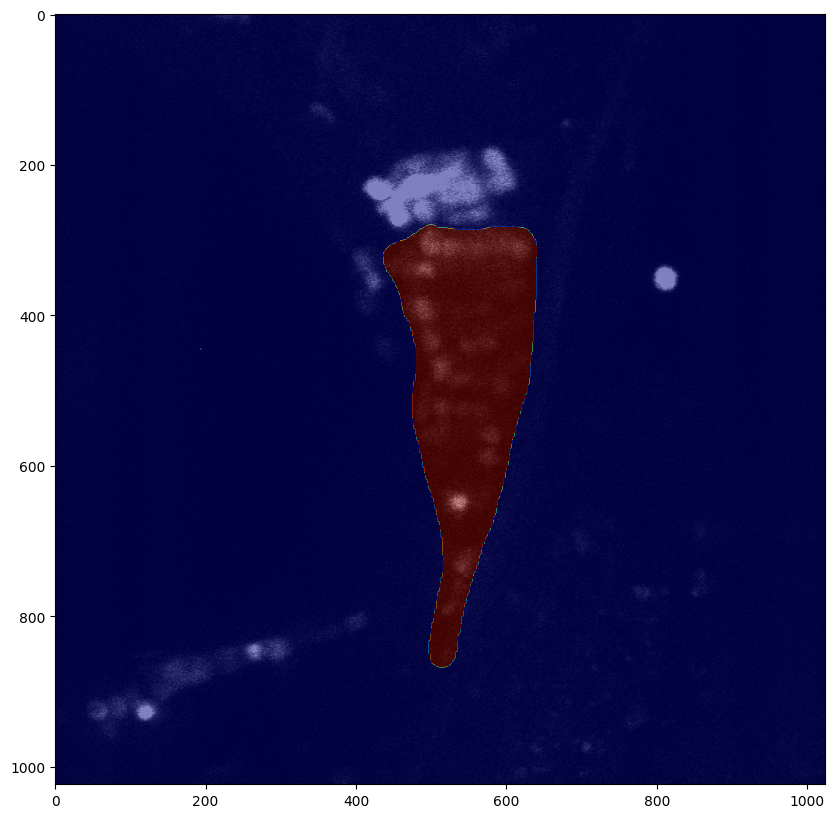

In [9]:
# Plot the masks on the reference image
region = "vagal_ganglion"
mask = imread(Path(masks_folder).joinpath(f"{region}.tif"))

plt.figure(figsize=(10, 10))
plt.imshow(reference_img, cmap='gray', vmax=300)
plt.imshow(mask, alpha=0.5, cmap="jet")

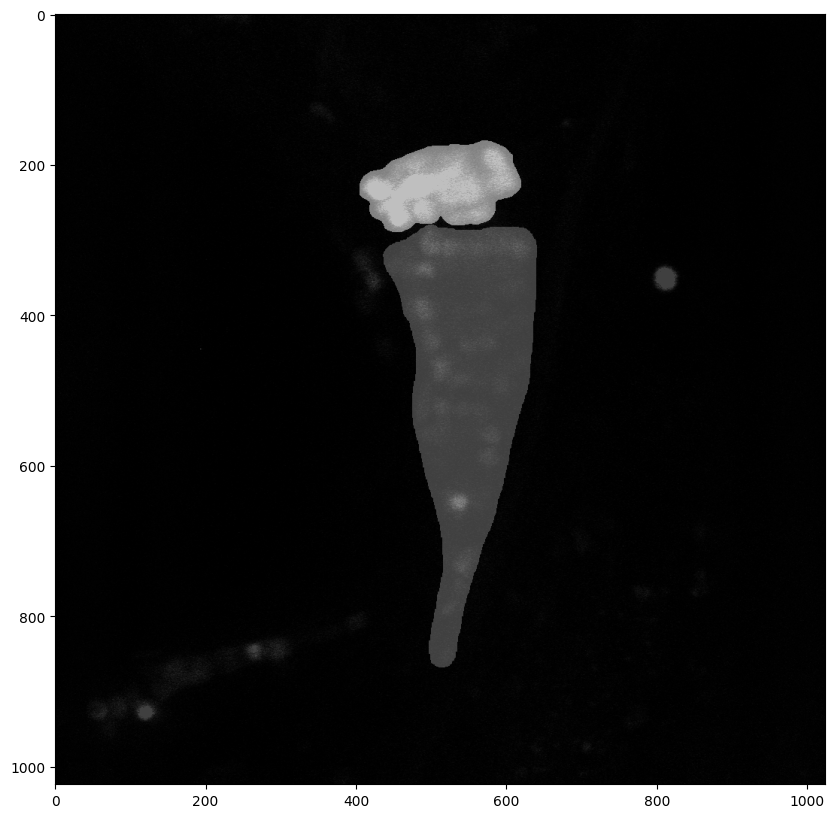

In [10]:
# Plot multiple masks on the reference image
regions = ["vagal_ganglion", "posterior_lateral_line_ganglion"]

plt.figure(figsize=(10, 10))
plt.imshow(reference_img, cmap="gray", vmax=300)

for region in regions:
	mask = imread(Path(masks_folder).joinpath(f"{region}.tif"))
	plt.imshow(mask, alpha=0.5, cmap="gray")

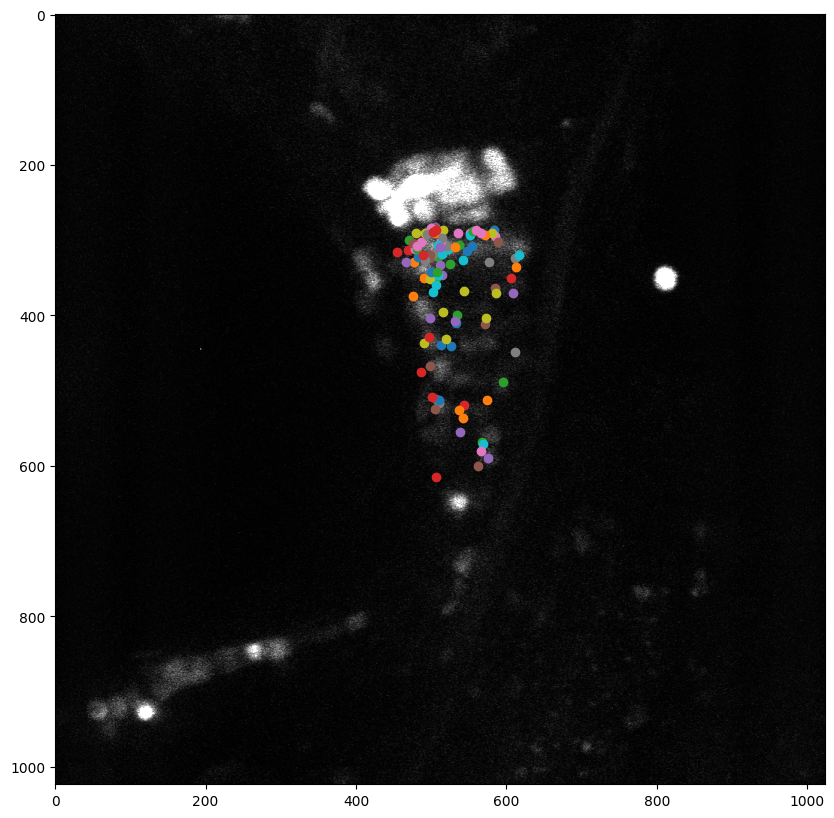

In [11]:
# Visualize the aligned points on the reference image with a given region
region = "vagal_ganglion"

plt.figure(figsize=(10, 10))
plt.imshow(reference_img, cmap="gray", vmax=300)
for i, row in df.iterrows():
	try:
		if region in row["region_aligned"]:
			plt.scatter(row["com_aligned"][0], row["com_aligned"][1])
	except TypeError:
		pass